In [8]:
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.7/200.7 MB 54.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 51.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 57.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.8/663.8 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

print("Libs importées")

Libs importées ✅


In [51]:
import pandas as pd
df = pd.read_csv("invocation_count.csv", index_col=0, parse_dates=True)
df_hour = df.resample("T").sum().rename(columns={"count":"requests"})
df_hour = df_hour.interpolate()
df_hour.head()

/var/folders/sk/p82d2pd15798kd0fm33g2n740000gn/T/ipykernel_19096/2376354485.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_hour = df.resample("T").sum().rename(columns={"count":"requests"})


,requests
period,
1998-04-30 21:30:00,2
1998-04-30 21:31:00,11
1998-04-30 21:32:00,16
1998-04-30 21:33:00,7
1998-04-30 21:34:00,3


/var/folders/sk/p82d2pd15798kd0fm33g2n740000gn/T/ipykernel_19096/3178567768.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample("H").sum()


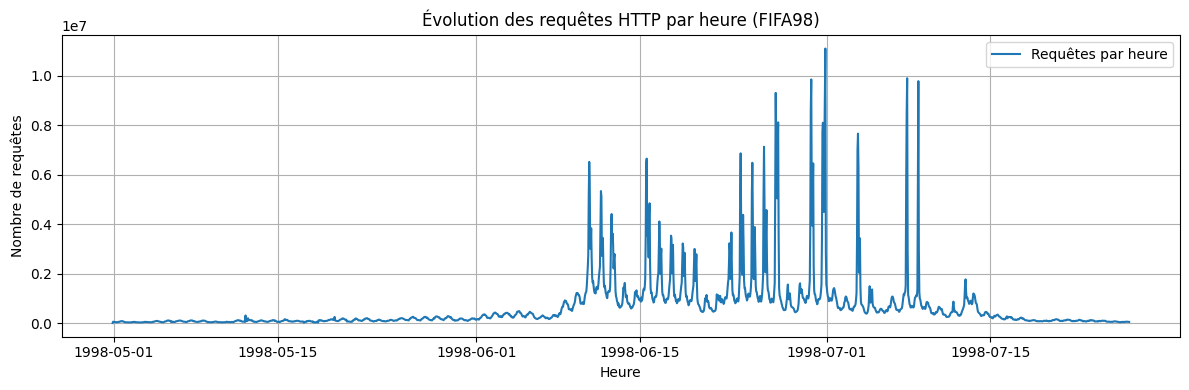

In [52]:
df_hourly = df.resample("H").sum()

# Tracé de la courbe
plt.figure(figsize=(12, 4))
plt.plot(df_hourly.index, df_hourly['count'], label='Requêtes par heure')
plt.xlabel("Heure")
plt.ylabel("Nombre de requêtes")
plt.title("Évolution des requêtes HTTP par heure (FIFA98)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Fonction pour transformer une série temporelle en problème supervisé
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Entrées t-n, ..., t-1
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var(t-{i})']

    # Sorties t, t+1, ...
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['var(t)']
        else:
            names += [f'var(t+{i})']

    # Concaténer et nettoyer
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg


In [ ]:
# Exemple : dataframe avec colonne 'requests' et index datetime
df = df_hour.copy()
df = df[['requests']]  # on garde uniquement la série

# Normalisation MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

# Création du dataset supervisé avec 24 heures de contexte (n_in)
n_hours = 24
supervised = series_to_supervised(scaled, n_in=n_hours, n_out=1)
print(supervised.head())

# Split en X et y
X = supervised.iloc[:, :-1].values
y = supervised.iloc[:, -1].values


    var(t-24)  var(t-23)  var(t-22)  var(t-21)  var(t-20)  var(t-19)  \
24   0.000009   0.000048   0.000070   0.000031   0.000013   0.000009   
25   0.000048   0.000070   0.000031   0.000013   0.000009   0.000013   
26   0.000070   0.000031   0.000013   0.000009   0.000013   0.000017   
27   0.000031   0.000013   0.000009   0.000013   0.000017   0.000022   
28   0.000013   0.000009   0.000013   0.000017   0.000022   0.000039   

    var(t-18)  var(t-17)  var(t-16)  var(t-15)  ...  var(t-9)  var(t-8)  \
24   0.000013   0.000017   0.000022   0.000039  ...  0.000017  0.000017   
25   0.000017   0.000022   0.000039   0.000004  ...  0.000017  0.000139   
26   0.000022   0.000039   0.000004   0.000022  ...  0.000139  0.000065   
27   0.000039   0.000004   0.000022   0.000009  ...  0.000065  0.000009   
28   0.000004   0.000022   0.000009   0.000017  ...  0.000009  0.000009   

    var(t-7)  var(t-6)  var(t-5)  var(t-4)  var(t-3)  var(t-2)  var(t-1)  \
24  0.000139  0.000065  0.000009  0.0000

In [43]:
# 70% train, 30% test
n_train = int(len(X) * 0.7)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

# Reshape pour LSTM : [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_hours, 1))
X_test = X_test.reshape((X_test.shape[0], n_hours, 1))

print("X_train shape :", X_train.shape)
print("X_test shape  :", X_test.shape)


X_train shape : (87700, 24, 1)
X_test shape  : (37586, 24, 1)


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',         # Surveille la perte de validation
    factor=0.5,                 # Divise le learning rate par 2
    patience=5,                 # Attends 5 epochs sans amélioration
    min_lr=1e-6,                # Ne descend pas en dessous de ce seuil
    verbose=1
)

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es, reduce_lr],
    verbose=1
)




Epoch 1/100
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 9.6684e-05 - val_loss: 2.6573e-04 - learning_rate: 0.0010
Epoch 2/100
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 5.8772e-05 - val_loss: 1.1633e-04 - learning_rate: 0.0010
Epoch 3/100
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 4.9621e-05 - val_loss: 7.8456e-05 - learning_rate: 0.0010
Epoch 4/100
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 4.8365e-05 - val_loss: 6.2214e-05 - learning_rate: 0.0010
Epoch 5/100
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 4.6011e-05 - val_loss: 1.0383e-04 - learning_rate: 0.0010
Epoch 6/100
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 4.6083e-05 - val_loss: 6.9768e-05 - learning_rate: 0.0010
Epoch 7/100
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4306e-05
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 4.2490e-05 - val_loss: 7.5354e-05 - learning_rate: 0.0010
Epoch 8/

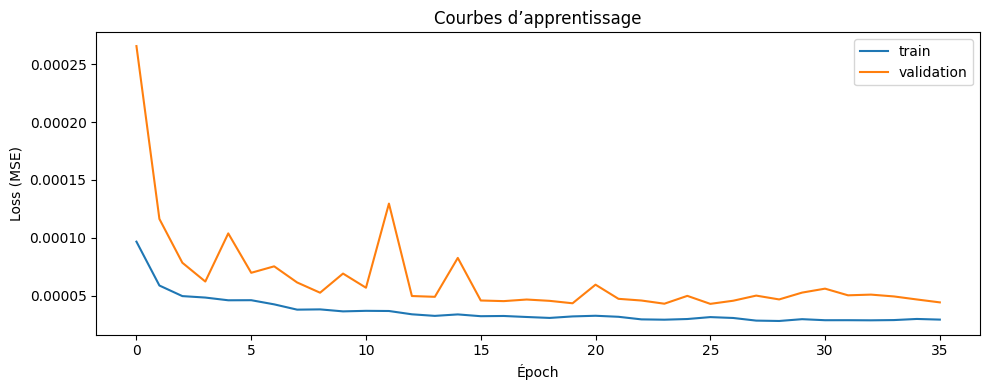

In [46]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Courbes d’apprentissage')
plt.xlabel('Époch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()


1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
RMSE: 851.69
MAE : 406.71


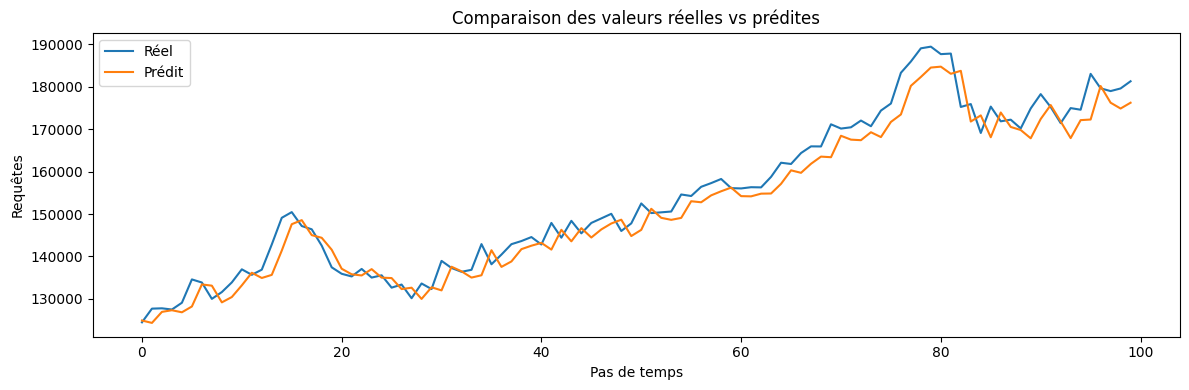

In [47]:
# Prédictions
y_pred = model.predict(X_test)

# Revenir à l’échelle d’origine
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_inv = scaler.inverse_transform(y_pred).ravel()

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

# Visualisation des 100 premiers points
plt.figure(figsize=(12,4))
plt.plot(y_test_inv[:100], label='Réel')
plt.plot(y_pred_inv[:100], label='Prédit')
plt.title("Comparaison des valeurs réelles vs prédites")
plt.xlabel("Pas de temps")
plt.ylabel("Requêtes")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# Sauvegarde du modèle entraîné
import joblib

model.save("lstm_predictor.keras")
joblib.dump(scaler, 'scaler.pkl')
print("Modèle sauvegardé sous lstm_predictor")

✅ Modèle sauvegardé sous lstm_predictor
